# Environment

---



## Prepare the data

---



In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meshadelbadran","key":"37b1a39cebd51d3491d8bbf17150011e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d zaynena/selfdriving-car-simulator

Dataset URL: https://www.kaggle.com/datasets/zaynena/selfdriving-car-simulator
License(s): copyright-authors
 98% 2.20G/2.24G [00:19<00:01, 44.3MB/s]
100% 2.24G/2.24G [00:20<00:00, 120MB/s] 


In [ ]:
!unzip selfdriving-car-simulator.zip -d data

## Prepare the libraries

---



In [5]:
import os
import random
import warnings
from typing import Tuple
from tqdm import tqdm

import cv2
import ntpath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Suppress warnings
warnings.filterwarnings("ignore")


# Data understanding

---

### 📦 **About Dataset**

#### **Context**
This is an image dataset generated by the **Udacity Self-Driving Car Simulator**.  
The dataset contains driving images from cameras mounted on a virtual vehicle and corresponding driving parameters such as steering angle, throttle, brake, and speed.

---

### 📁 **Dataset Structure**

| Folder | Description | Size
|--------|-------------|------
| **track1data/** | Contains images and CSV log file collected only from Track 1 | 31,845
| **track2data/** | Contains images and CSV log file collected only from Track 2 | 65,484
| **dataset/** | Contains all images from both **track1data/** and **track2data/** combined | 97,329

---

### 📄 **CSV File Columns**

| Column | Meaning |
|--------|---------|
| **Center** | Center camera image path |
| **Left** | Left camera image path |
| **Right** | Right camera image path |
| **Steering** | Steering wheel angle |
| **Throttle** | Throttle value (acceleration) |
| **Brake** | Brake value |
| **Speed** | Vehicle speed |

---

|index|Steering|Throttle|Brake|Speed|
|---|---|---|---|---|
|count|21828\.0|21828\.0|21828\.0|21828\.0|
|mean|-0\.01318031883818948|0\.20500802925959638|0\.028569632292197635|8\.782329734606764|
|std|0\.46189122305571556|0\.28688580517629336|0\.1198930944174388|2\.7422589671476296|
|min|-1\.0|0\.0|0\.0|1\.835208e-05|
|25%|-0\.1|0\.0|0\.0|7\.1821675|
|50%|0\.0|0\.0|0\.0|8\.93185|
|75%|0\.05|0\.3538586|0\.0|10\.4863525|
|max|1\.0|1\.0|1\.0|19\.29511|

---

| Steering Value      | Direction     |
|---------------------|---------------|
| Less than 0 (`< 0`) | Turn **Right**|
| Equal to 0 (`= 0`) | Go **Straight**|
| Greater than 0 (`> 0`) | Turn **Left** |


# Data Processing

---



## Data loading

---



In [6]:
# Path to driving log file
CSV_PATH = "/content/data/dataset/dataset/driving_log.csv"


In [7]:
# Driving log columns
COLUMNS = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']

# Load dataset
data = pd.read_csv(CSV_PATH, names=COLUMNS)

# Preview data
data.sample(100)


,Center,Left,Right,Steering,Throttle,Brake,Speed
5381,Desktop\track1data\IMG\center_2019_04_02_19_31...,Desktop\track1data\IMG\left_2019_04_02_19_31_5...,Desktop\track1data\IMG\right_2019_04_02_19_31_...,0.00,0.192666,0.000000,12.165560
14843,Desktop\track2data\IMG\center_2019_04_02_18_10...,Desktop\track2data\IMG\left_2019_04_02_18_10_3...,Desktop\track2data\IMG\right_2019_04_02_18_10_...,0.90,0.000000,0.177990,8.308810
11812,Desktop\track2data\IMG\center_2019_04_02_18_07...,Desktop\track2data\IMG\left_2019_04_02_18_07_0...,Desktop\track2data\IMG\right_2019_04_02_18_07_...,0.00,0.097531,0.000000,9.908340
14626,Desktop\track2data\IMG\center_2019_04_02_18_10...,Desktop\track2data\IMG\left_2019_04_02_18_10_1...,Desktop\track2data\IMG\right_2019_04_02_18_10_...,-1.00,0.000000,0.390527,3.474050
3797,Desktop\track1data\IMG\center_2019_04_02_19_30...,Desktop\track1data\IMG\left_2019_04_02_19_30_0...,Desktop\track1data\IMG\right_2019_04_02_19_30_...,0.00,0.000000,0.000000,11.696350
...,...,...,...,...,...,...,...
12253,Desktop\track2data\IMG\center_2019_04_02_18_07...,Desktop\track2data\IMG\left_2019_04_02_18_07_3...,Desktop\track2data\IMG\right_2019_04_02_18_07_...,-0.15,0.000000,0.000000,4.585145
25372,Desktop\track2data\IMG\center_2019_04_02_18_22...,Desktop\track2data\IMG\left_2019_04_02_18_22_4...,Desktop\track2data\IMG\right_2019_04_02_18_22_...,0.00,0.375720,0.000000,10.074720
9530,Desktop\track1data\IMG\center_2019_04_02_19_36...,Desktop\track1data\IMG\left_2019_04_02_19_36_5...,Desktop\track1data\IMG\right_2019_04_02_19_36_...,0.00,0.330567,0.000000,14.143970
14860,Desktop\track2data\IMG\center_2019_04_02_18_10...,Desktop\track2data\IMG\left_2019_04_02_18_10_3...,Desktop\track2data\IMG\right_2019_04_02_18_10_...,0.05,0.433352,0.000000,9.646449


In [8]:
# Show basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32443 entries, 0 to 32442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Center    32443 non-null  object 
 1   Left      32443 non-null  object 
 2   Right     32443 non-null  object 
 3   Steering  32443 non-null  float64
 4   Throttle  32443 non-null  float64
 5   Brake     32443 non-null  float64
 6   Speed     32443 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.7+ MB


In [9]:
# Show basic statistical summary of the data
data.describe()

,Steering,Throttle,Brake,Speed
count,32443.000000,32443.000000,32443.000000,32443.000000
mean,-0.020874,0.178208,0.019222,10.211380
std,0.389218,0.259095,0.099251,3.268863
min,-1.000000,0.000000,0.000000,0.000003
25%,0.000000,0.000000,0.000000,8.145018
50%,0.000000,0.000000,0.000000,10.250250
75%,0.000000,0.299458,0.000000,12.455875
max,1.000000,1.000000,1.000000,21.949390


In [10]:
# Normalize image paths (convert Windows slashes to Unix)
def normalize_path(p: str) -> str:
    return p.replace("\\", "/")

# Apply normalization
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(normalize_path)


In [11]:
def get_filename(path: str) -> str:
    """Return filename from full path."""
    return ntpath.basename(path)

# Extract filenames
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(get_filename)

# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
14870,center_2019_04_02_18_10_35_200.jpg,left_2019_04_02_18_10_35_200.jpg,right_2019_04_02_18_10_35_200.jpg,0.65,0.542080,0.0,5.056504
7886,center_2019_04_02_19_34_57_749.jpg,left_2019_04_02_19_34_57_749.jpg,right_2019_04_02_19_34_57_749.jpg,0.35,0.000000,0.0,11.458880
454,center_2019_04_02_19_26_06_375.jpg,left_2019_04_02_19_26_06_375.jpg,right_2019_04_02_19_26_06_375.jpg,0.00,0.109151,0.0,12.563050
22743,center_2019_04_02_18_19_46_263.jpg,left_2019_04_02_18_19_46_263.jpg,right_2019_04_02_18_19_46_263.jpg,0.00,0.243477,0.0,7.888825
24431,center_2019_04_02_18_21_43_793.jpg,left_2019_04_02_18_21_43_793.jpg,right_2019_04_02_18_21_43_793.jpg,0.90,0.603329,0.0,11.395630
...,...,...,...,...,...,...,...
18386,center_2019_04_02_18_14_41_150.jpg,left_2019_04_02_18_14_41_150.jpg,right_2019_04_02_18_14_41_150.jpg,0.20,0.000000,0.0,4.318421
1032,center_2019_04_02_19_26_47_867.jpg,left_2019_04_02_19_26_47_867.jpg,right_2019_04_02_19_26_47_867.jpg,0.00,0.000000,0.0,12.998990
27846,center_2019_04_02_18_25_42_655.jpg,left_2019_04_02_18_25_42_655.jpg,right_2019_04_02_18_25_42_655.jpg,-0.60,0.000000,0.0,11.143450
26035,center_2019_04_02_18_23_35_991.jpg,left_2019_04_02_18_23_35_991.jpg,right_2019_04_02_18_23_35_991.jpg,-0.10,0.098962,0.0,0.006876


## Data balancing

---



In [12]:
# Steering distribution parameters
NUM_BINS = 25
SAMPLES_PER_BIN = 1600  # Hyperparameter

# Steering histogram
hist, bins = np.histogram(data["Steering"], bins=NUM_BINS)
print("Bin edges:", bins)


Bin edges: [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


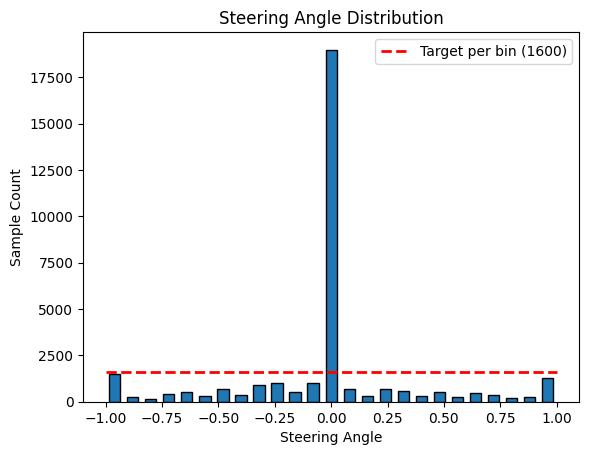

In [13]:
# Bin centers
centers = (bins[:-1] + bins[1:]) / 2

# Plot steering distribution
plt.bar(centers, hist, width=0.05, edgecolor='k')
plt.plot(
    [data["Steering"].min(), data["Steering"].max()],
    [SAMPLES_PER_BIN, SAMPLES_PER_BIN],
    "r--",
    linewidth=2,
    label=f"Target per bin ({SAMPLES_PER_BIN})"
)

plt.title("Steering Angle Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")
plt.legend()
plt.show()

In [14]:
print(f"Total samples: {len(data)}")

Total samples: 32443


In [15]:
remove_list = []
steering_vals = data["Steering"].values

for i in range(NUM_BINS):
    if i < NUM_BINS - 1:
        mask = (steering_vals >= bins[i]) & (steering_vals < bins[i + 1])
    else:
        mask = (steering_vals >= bins[i]) & (steering_vals <= bins[i + 1])

    indices = np.where(mask)[0]
    np.random.shuffle(indices)
    remove_list.extend(indices[SAMPLES_PER_BIN:])


In [16]:
# Balance dataset by dropping excess samples
data_balanced = data.drop(remove_list)
print(f"Samples retained: {len(data_balanced)}")

Samples retained: 15046


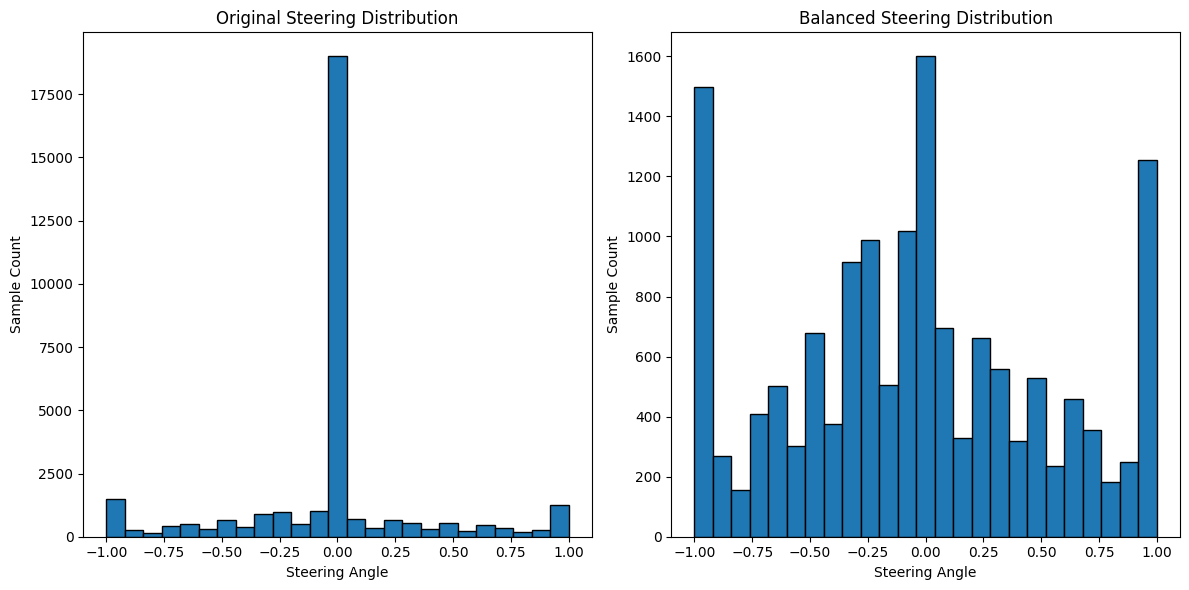

In [17]:
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(data["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Original Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

# Balanced distribution
plt.subplot(1, 2, 2)
plt.hist(data_balanced["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Balanced Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

plt.tight_layout()
plt.show()

## Data splitting

---



In [18]:
DATA_DIR = '/content/data/dataset/dataset/IMG'

In [19]:
def load_images_and_steering(data_dir: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Load image paths and steering angles with side camera corrections."""
    image_paths, steerings = [], []

    correction = 0.15
    for _, row in df.iterrows():
        center, left, right = row['Center'], row['Left'], row['Right']
        steer = float(row['Steering'])

        image_paths.extend([
            os.path.join(data_dir, center),
            os.path.join(data_dir, left),
            os.path.join(data_dir, right),
        ])
        steerings.extend([
            steer,
            steer  + correction,
            steer - correction,
        ])

    return np.array(image_paths), np.array(steerings)

# Usage
image_paths, steerings = load_images_and_steering(DATA_DIR + '/', data_balanced)

In [26]:
# length
print(f"Total images: {len(image_paths)}")

Total images: 45138


In [20]:
def fix_path(path: str) -> str:
    return path.replace("\\", "/")

for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(fix_path)

In [21]:
# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
20226,center_2019_04_02_18_16_50_026.jpg,left_2019_04_02_18_16_50_026.jpg,right_2019_04_02_18_16_50_026.jpg,1.00,0.000000,0.000000,7.039790
13028,center_2019_04_02_18_08_26_277.jpg,left_2019_04_02_18_08_26_277.jpg,right_2019_04_02_18_08_26_277.jpg,-0.60,0.000000,0.536044,9.688881
14235,center_2019_04_02_18_09_50_630.jpg,left_2019_04_02_18_09_50_630.jpg,right_2019_04_02_18_09_50_630.jpg,-1.00,0.689384,0.000000,5.155459
21584,center_2019_04_02_18_18_25_183.jpg,left_2019_04_02_18_18_25_183.jpg,right_2019_04_02_18_18_25_183.jpg,0.00,0.000000,0.000000,13.135220
19128,center_2019_04_02_18_15_33_170.jpg,left_2019_04_02_18_15_33_170.jpg,right_2019_04_02_18_15_33_170.jpg,0.00,0.000000,0.000000,9.245255
...,...,...,...,...,...,...,...
26391,center_2019_04_02_18_24_00_772.jpg,left_2019_04_02_18_24_00_772.jpg,right_2019_04_02_18_24_00_772.jpg,-0.65,0.000000,0.759162,9.045168
1891,center_2019_04_02_19_27_48_727.jpg,left_2019_04_02_19_27_48_727.jpg,right_2019_04_02_19_27_48_727.jpg,0.00,1.000000,0.000000,14.964100
15236,center_2019_04_02_18_11_00_536.jpg,left_2019_04_02_18_11_00_536.jpg,right_2019_04_02_18_11_00_536.jpg,-0.90,0.640434,0.000000,9.538947
4927,center_2019_04_02_19_31_26_159.jpg,left_2019_04_02_19_31_26_159.jpg,right_2019_04_02_19_31_26_159.jpg,0.00,0.209859,0.000000,13.119480


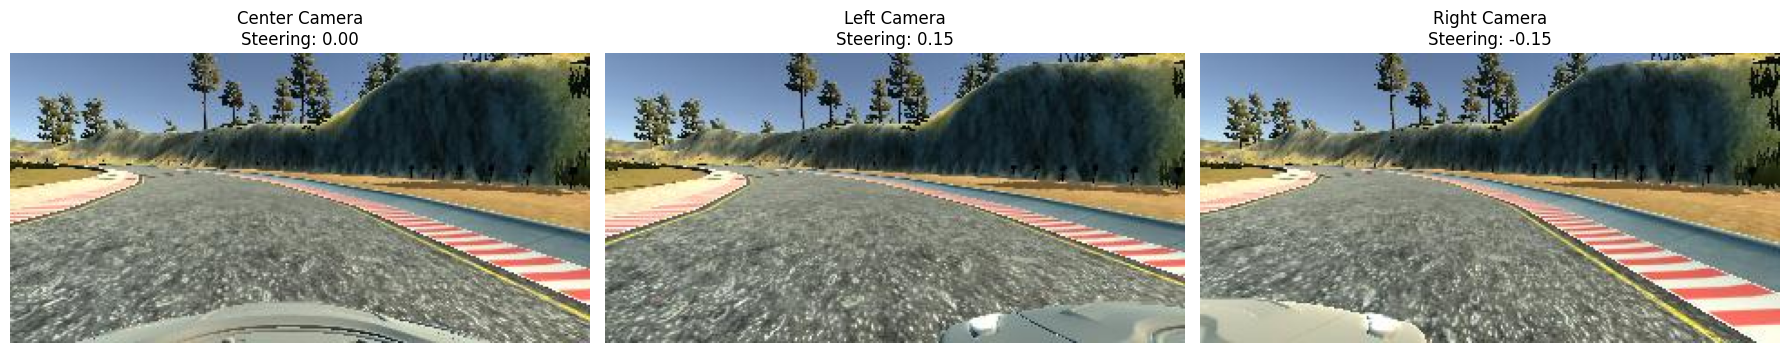

In [22]:
sample_idx = 10
start_idx = sample_idx * 3

plt.figure(figsize=(18, 6))

camera_names = ['Center', 'Left', 'Right']

for i in range(3):
    img_path = image_paths[start_idx + i]
    steering_angle = steerings[start_idx + i]

    img = Image.open(img_path)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'{camera_names[i]} Camera\nSteering: {steering_angle:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Split data: 75% train, 15% validation
# Split train: 75% train, 15% test
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, steerings, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val=train_test_split(
   X_train, y_train, test_size=0.15, random_state=42
)


print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 32611
Validation samples: 5756
Test samples: 6771


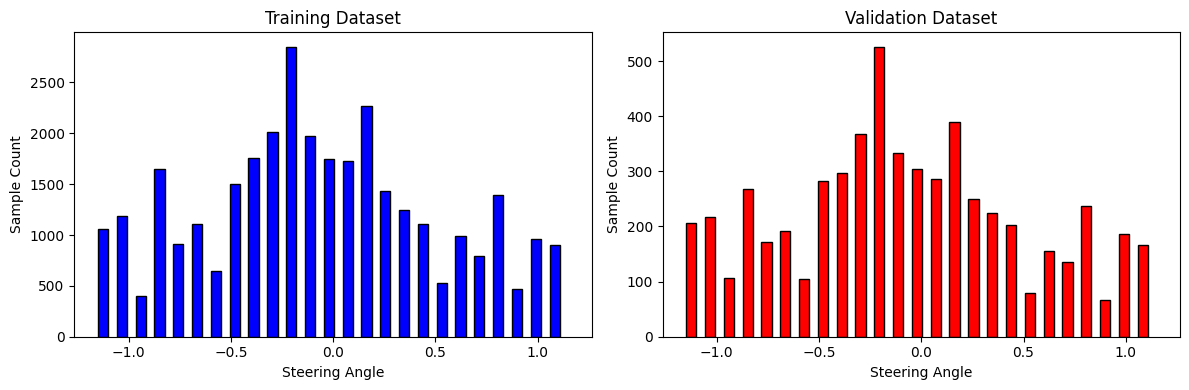

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training distribution
axes[0].hist(y_train, bins=NUM_BINS, width=0.05, color='blue', edgecolor='black')
axes[0].set(title='Training Dataset', xlabel='Steering Angle', ylabel='Sample Count')

# Validation distribution
axes[1].hist(y_val, bins=NUM_BINS, width=0.05, color='red', edgecolor='black')
axes[1].set(title='Validation Dataset', xlabel='Steering Angle', ylabel='Sample Count')

plt.tight_layout()
plt.show()

## Data augmentation

---



### Data augmentation (Nvidia)

---



In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

def normalize_nvidia(image, **kwargs):
    return image.astype(np.float32) / 255.0

def get_transforms_list(Nv):
    transforms = [
        A.Crop(x_min=0, y_min=60, x_max=320, y_max=135, p=1.0),
        A.GaussianBlur(blur_limit=3, p=1.0),
    ]

    if Nv:
        transforms.extend([
            A.Lambda(image=lambda img, **kwargs: cv2.cvtColor(img, cv2.COLOR_RGB2YUV), p=1.0),
            A.Resize(height=66, width=200, interpolation=cv2.INTER_AREA, p=1.0),
            A.Lambda(image=normalize_nvidia, p=1.0),
        ])
    else:
        transforms.extend([
            A.Resize(height=64, width=192, interpolation=cv2.INTER_AREA, p=1.0),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ])

    return transforms

def get_train_transforms(Nv):
    aug_list = [
        A.Affine(scale=(1.0, 1.4), mode=cv2.BORDER_REPLICATE, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.8, 0.2), contrast_limit=0, p=0.5),
    ]

    full_pipeline = aug_list + get_transforms_list(Nv) + [ToTensorV2(p=1.0)]

    return A.Compose(full_pipeline)

def get_val_transforms(Nv):
    full_pipeline = get_transforms_list(Nv) + [ToTensorV2(p=1.0)]

    return A.Compose(full_pipeline)

def get_test_transforms(Nv):
    full_pipeline = get_transforms_list(Nv) + [ToTensorV2(p=1.0)]

    return A.Compose(full_pipeline)



# Dataset & DataLoader

---



In [27]:
class DrivingDataset(Dataset):
    def __init__(self, image_paths, steerings, transform=None, is_train=False) :
        self.image_paths = image_paths
        self.steerings = steerings
        self.transform = transform
        self.is_train = is_train

    def _random_flip(self, img, steering):
        if random.random() < 0.5:
            return cv2.flip(img, 1), -steering
        return img, steering

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steerings[idx]

        img = np.array(Image.open(img_path).convert('RGB'))

        if self.is_train:
            img, steering = self._random_flip(img, steering)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, torch.tensor(steering, dtype=torch.float32)


In [28]:
# Create datasets
train_dataset = DrivingDataset(X_train, y_train, transform=get_train_transforms(True), is_train=True)
val_dataset = DrivingDataset(X_val, y_val, transform=get_val_transforms(True))
test_dataset = DrivingDataset(X_val, y_val, transform=get_val_transforms(True))

print(f"Training dataset: {len(train_dataset)} samples (with augmentation)")
print(f"Validation dataset: {len(val_dataset)} samples (no augmentation)")

batch_size = 64
print(f"Batch size: {batch_size}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
print(f"Train loader: {len(train_loader)} batches per epoch")

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
print(f"Validation loader: {len(val_loader)} batches per epoch")

Training dataset: 32611 samples (with augmentation)
Validation dataset: 5756 samples (no augmentation)
Batch size: 64
Train loader: 510 batches per epoch
Validation loader: 90 batches per epoch


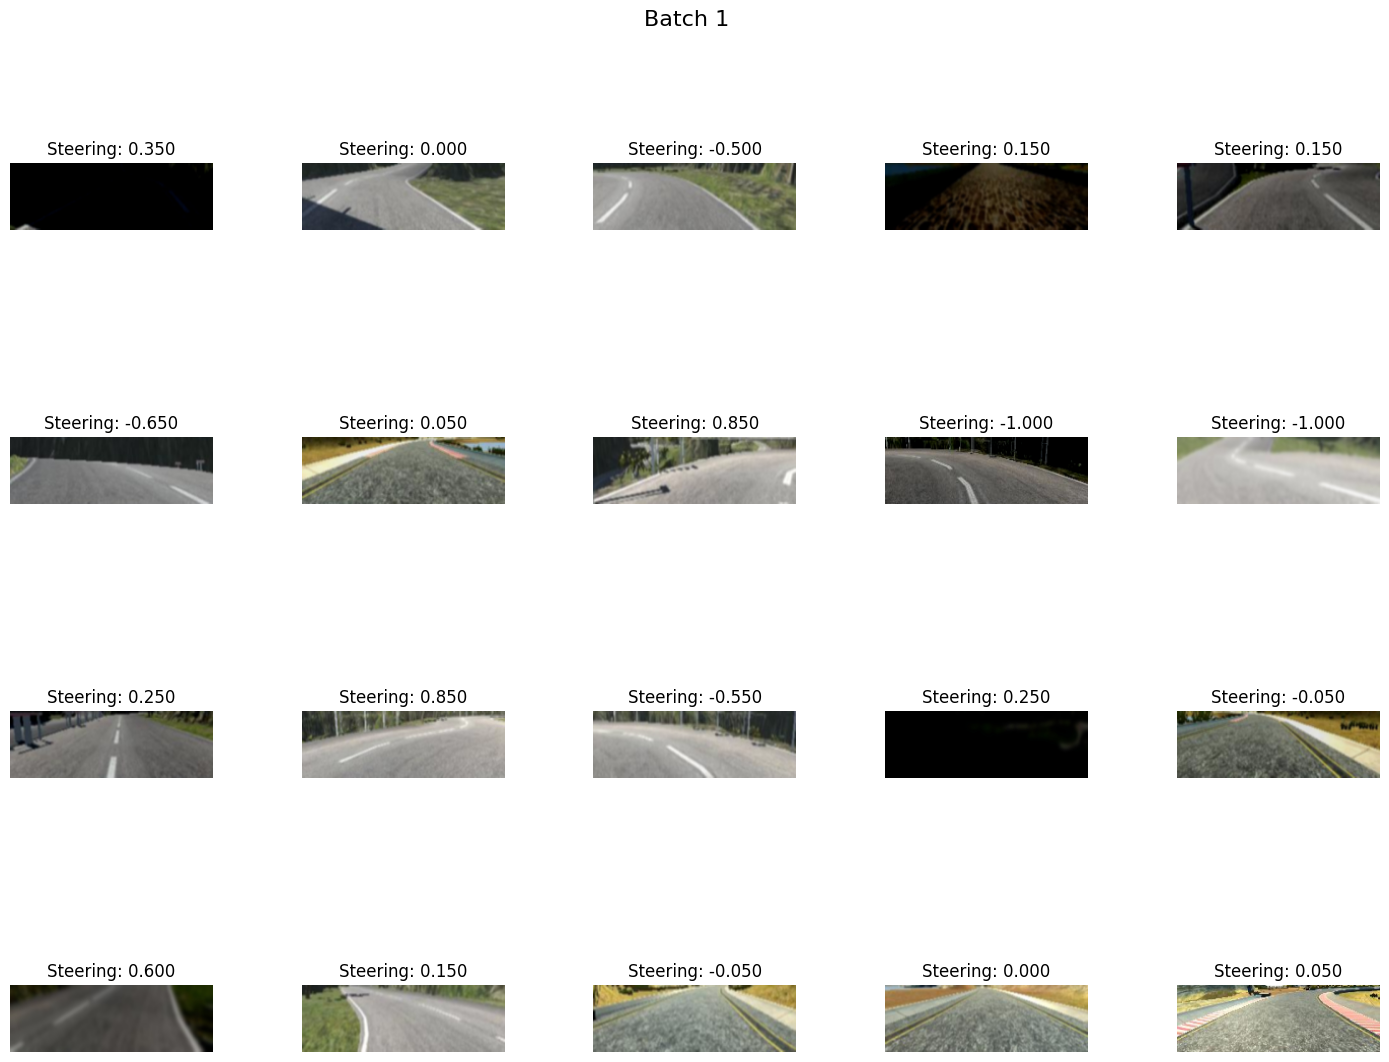

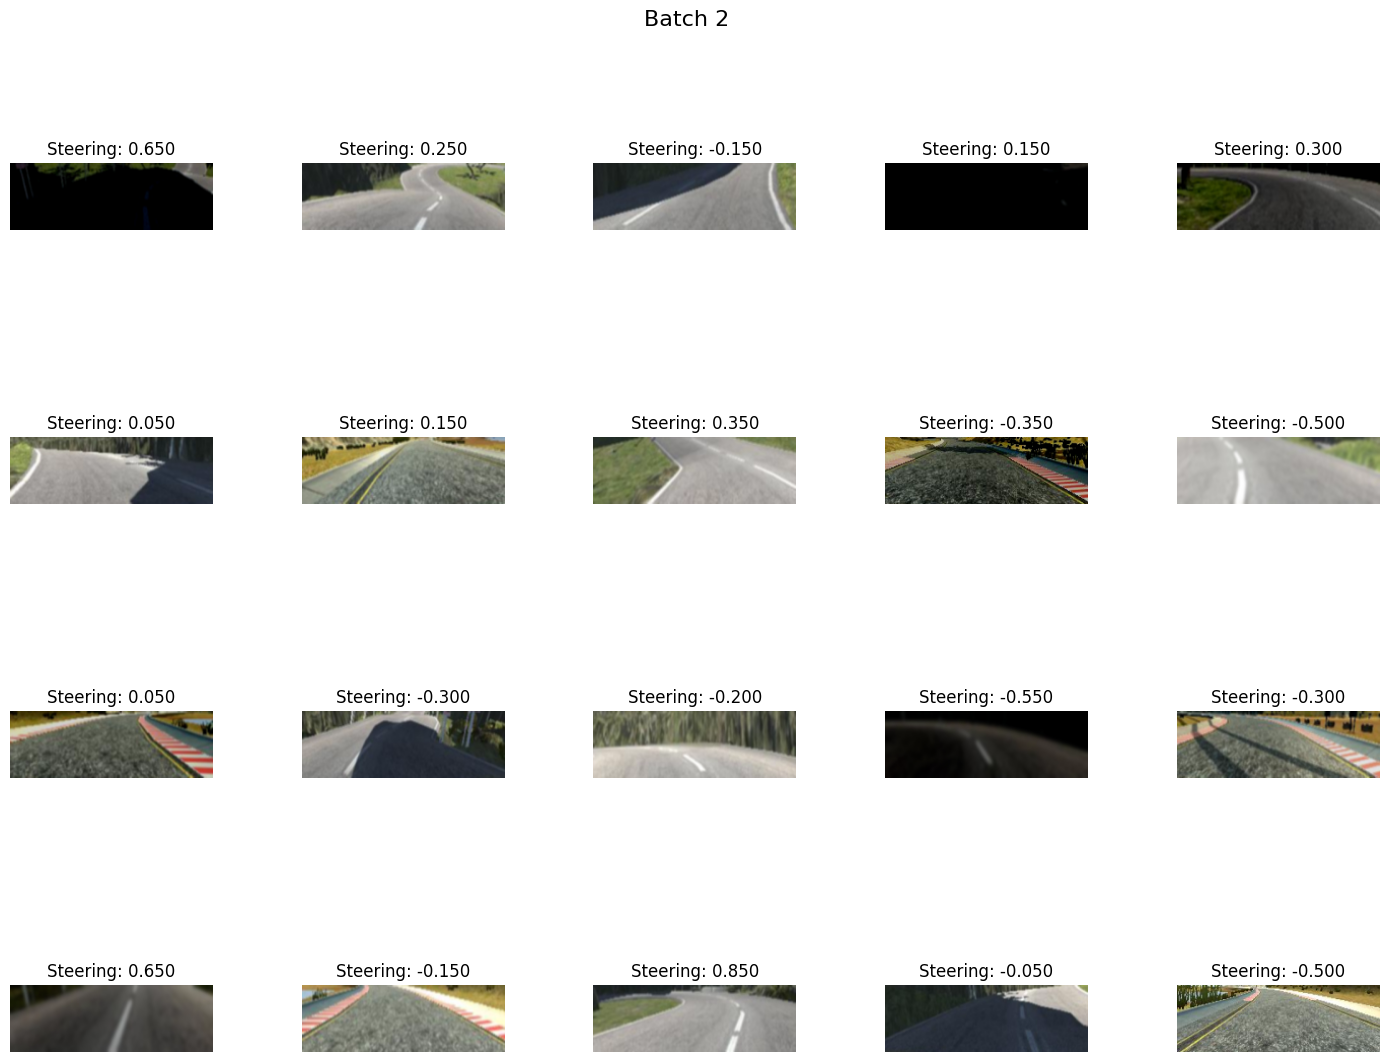

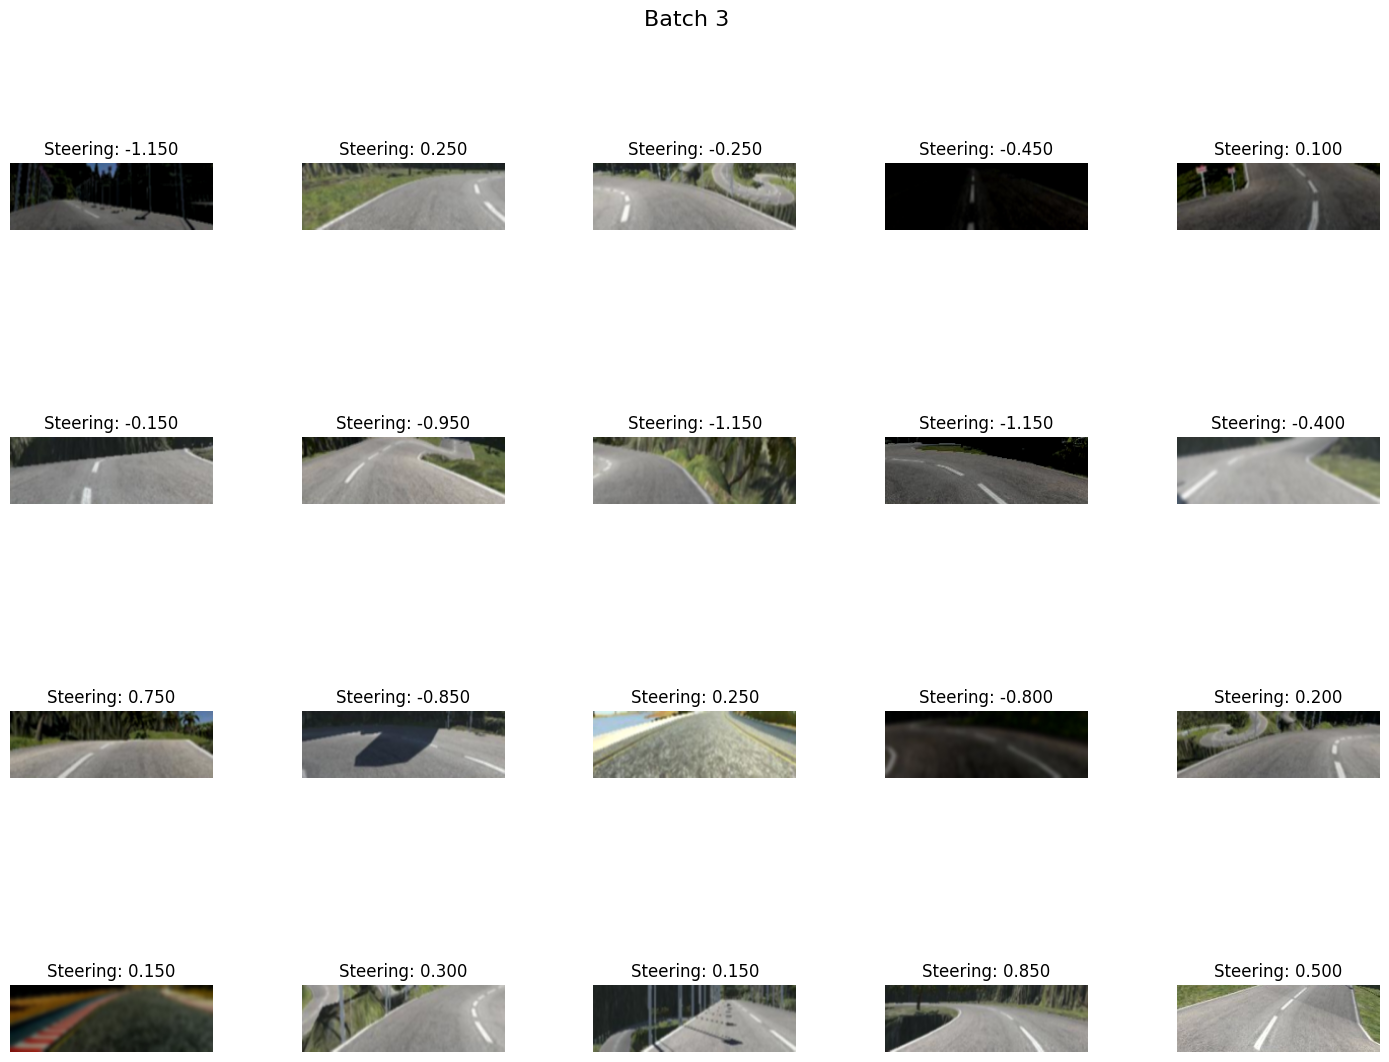

In [29]:
num_batches = 3
images_per_batch = 20
cols = 5
rows = (images_per_batch + cols - 1) // cols

for batch_idx, (images, steerings) in enumerate(train_loader):
    if batch_idx >= num_batches:
        break

    batch_size = images.size(0)
    n_show = min(images_per_batch, batch_size)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(f'Batch {batch_idx + 1}', fontsize=16)
    fig.tight_layout(pad=3.0)

    for i in range(n_show):
        r, c = divmod(i, cols)
        img_yuv = images[i].permute(1, 2, 0).cpu().numpy()
        img_rgb = cv2.cvtColor((img_yuv * 255).astype(np.uint8), cv2.COLOR_YUV2RGB)

        axs[r, c].imshow(img_rgb)
        axs[r, c].set_title(f'Steering: {steerings[i].item():.3f}')
        axs[r, c].axis('off')

    # Remove unused subplots
    for j in range(n_show, rows * cols):
        r, c = divmod(j, cols)
        fig.delaxes(axs[r, c])

    plt.show()


# Modeling

---



## Nvidia model

---



### Model architecture (Nvidia)

---



In [30]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(0.5)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 1 * 18, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

print("NvidiaModel class defined.")

NvidiaModel class defined.


### Model train (Nvidia)

---



In [31]:
model = NvidiaModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model ready on {device}. Loss: MSE. Optimizer: Adam.")


Model ready on cuda. Loss: MSE. Optimizer: Adam.


In [32]:
def train(model, loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, running_mae = 0.0, 0.0
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Training", ncols=120)

    for i, (images, steerings) in pbar:
        images, steerings = images.to(device), steerings.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, steerings)
        loss.backward()
        optimizer.step()

        mae = F.l1_loss(outputs, steerings, reduction='mean').item()

        running_loss += loss.item()
        running_mae += mae

        pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}", MAE=f"{running_mae/(i+1):.4f}")

    return running_loss / len(loader), running_mae / len(loader)

def validate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss, running_mae = 0.0, 0.0
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Validation", ncols=120)

    with torch.no_grad():
        for i, (images, steerings) in pbar:
            images, steerings = images.to(device), steerings.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, steerings)
            mae = F.l1_loss(outputs, steerings, reduction='mean').item()

            running_loss += loss.item()
            running_mae += mae

            pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}", MAE=f"{running_mae/(i+1):.4f}")

    return running_loss / len(loader), running_mae / len(loader)


In [33]:
best_val_loss = float('inf')
num_epochs = 25

for epoch in range(num_epochs):
    train_loss, train_mae = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_mae = validate(model, val_loader, criterion, device, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: Loss={train_loss:.4f}, MAE={train_mae:.4f} | "
          f"Val: Loss={val_loss:.4f}, MAE={val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "nvidia_model.pth")
        print(f"Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")

print("Training complete.")


Epoch 0 Validation: 100%|██████████████████████████████████████| 90/90 [00:08<00:00, 11.18it/s, MAE=0.3718, loss=0.2187]


Epoch 1/25 | Train: Loss=0.2683, MAE=0.4121 | Val: Loss=0.2187, MAE=0.3718
Saved best model at epoch 1 with val loss: 0.2187


Epoch 1 Validation: 100%|██████████████████████████████████████| 90/90 [00:06<00:00, 12.91it/s, MAE=0.3505, loss=0.1943]

Epoch 2/25 | Train: Loss=0.2306, MAE=0.3804 | Val: Loss=0.1943, MAE=0.3505
Saved best model at epoch 2 with val loss: 0.1943



Epoch 2 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 11.68it/s, MAE=0.3417, loss=0.1888]

Epoch 3/25 | Train: Loss=0.2191, MAE=0.3694 | Val: Loss=0.1888, MAE=0.3417
Saved best model at epoch 3 with val loss: 0.1888



Epoch 3 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 11.99it/s, MAE=0.3366, loss=0.1794]


Epoch 4/25 | Train: Loss=0.2076, MAE=0.3591 | Val: Loss=0.1794, MAE=0.3366
Saved best model at epoch 4 with val loss: 0.1794


Epoch 4 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 11.62it/s, MAE=0.3297, loss=0.1686]

Epoch 5/25 | Train: Loss=0.1935, MAE=0.3479 | Val: Loss=0.1686, MAE=0.3297
Saved best model at epoch 5 with val loss: 0.1686



Epoch 5 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 12.69it/s, MAE=0.3213, loss=0.1575]

Epoch 6/25 | Train: Loss=0.1817, MAE=0.3384 | Val: Loss=0.1575, MAE=0.3213
Saved best model at epoch 6 with val loss: 0.1575



Epoch 6 Validation: 100%|██████████████████████████████████████| 90/90 [00:06<00:00, 13.41it/s, MAE=0.3192, loss=0.1581]

Epoch 7/25 | Train: Loss=0.1754, MAE=0.3322 | Val: Loss=0.1581, MAE=0.3192



Epoch 7 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 12.80it/s, MAE=0.3139, loss=0.1531]

Epoch 8/25 | Train: Loss=0.1730, MAE=0.3297 | Val: Loss=0.1531, MAE=0.3139
Saved best model at epoch 8 with val loss: 0.1531



Epoch 8 Validation: 100%|██████████████████████████████████████| 90/90 [00:06<00:00, 13.30it/s, MAE=0.3077, loss=0.1452]


Epoch 9/25 | Train: Loss=0.1681, MAE=0.3245 | Val: Loss=0.1452, MAE=0.3077
Saved best model at epoch 9 with val loss: 0.1452


Epoch 9 Validation: 100%|██████████████████████████████████████| 90/90 [00:07<00:00, 11.49it/s, MAE=0.3064, loss=0.1437]


Epoch 10/25 | Train: Loss=0.1625, MAE=0.3189 | Val: Loss=0.1437, MAE=0.3064
Saved best model at epoch 10 with val loss: 0.1437


Epoch 10 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 11.47it/s, MAE=0.3027, loss=0.1402]

Epoch 11/25 | Train: Loss=0.1595, MAE=0.3160 | Val: Loss=0.1402, MAE=0.3027
Saved best model at epoch 11 with val loss: 0.1402



Epoch 11 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 11.03it/s, MAE=0.3018, loss=0.1398]


Epoch 12/25 | Train: Loss=0.1555, MAE=0.3131 | Val: Loss=0.1398, MAE=0.3018
Saved best model at epoch 12 with val loss: 0.1398


Epoch 12 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 10.96it/s, MAE=0.2963, loss=0.1346]

Epoch 13/25 | Train: Loss=0.1550, MAE=0.3119 | Val: Loss=0.1346, MAE=0.2963
Saved best model at epoch 13 with val loss: 0.1346



Epoch 13 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 11.03it/s, MAE=0.2928, loss=0.1299]

Epoch 14/25 | Train: Loss=0.1509, MAE=0.3088 | Val: Loss=0.1299, MAE=0.2928
Saved best model at epoch 14 with val loss: 0.1299



Epoch 14 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 11.73it/s, MAE=0.2925, loss=0.1305]

Epoch 15/25 | Train: Loss=0.1470, MAE=0.3047 | Val: Loss=0.1305, MAE=0.2925



Epoch 15 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 11.42it/s, MAE=0.2899, loss=0.1261]


Epoch 16/25 | Train: Loss=0.1446, MAE=0.3025 | Val: Loss=0.1261, MAE=0.2899
Saved best model at epoch 16 with val loss: 0.1261


Epoch 16 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 11.00it/s, MAE=0.2873, loss=0.1256]

Epoch 17/25 | Train: Loss=0.1426, MAE=0.3008 | Val: Loss=0.1256, MAE=0.2873
Saved best model at epoch 17 with val loss: 0.1256



Epoch 17 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 10.89it/s, MAE=0.2832, loss=0.1210]

Epoch 18/25 | Train: Loss=0.1380, MAE=0.2959 | Val: Loss=0.1210, MAE=0.2832
Saved best model at epoch 18 with val loss: 0.1210



Epoch 18 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 11.10it/s, MAE=0.2799, loss=0.1185]

Epoch 19/25 | Train: Loss=0.1379, MAE=0.2962 | Val: Loss=0.1185, MAE=0.2799
Saved best model at epoch 19 with val loss: 0.1185



Epoch 19 Validation: 100%|█████████████████████████████████████| 90/90 [00:08<00:00, 11.17it/s, MAE=0.2825, loss=0.1213]

Epoch 20/25 | Train: Loss=0.1333, MAE=0.2913 | Val: Loss=0.1213, MAE=0.2825



Epoch 20 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 12.33it/s, MAE=0.2774, loss=0.1154]

Epoch 21/25 | Train: Loss=0.1325, MAE=0.2908 | Val: Loss=0.1154, MAE=0.2774
Saved best model at epoch 21 with val loss: 0.1154



Epoch 21 Validation: 100%|█████████████████████████████████████| 90/90 [00:06<00:00, 12.89it/s, MAE=0.2766, loss=0.1155]

Epoch 22/25 | Train: Loss=0.1297, MAE=0.2880 | Val: Loss=0.1155, MAE=0.2766



Epoch 22 Validation: 100%|█████████████████████████████████████| 90/90 [00:06<00:00, 13.34it/s, MAE=0.2754, loss=0.1144]

Epoch 23/25 | Train: Loss=0.1292, MAE=0.2884 | Val: Loss=0.1144, MAE=0.2754
Saved best model at epoch 23 with val loss: 0.1144



Epoch 23 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 12.62it/s, MAE=0.2765, loss=0.1146]

Epoch 24/25 | Train: Loss=0.1274, MAE=0.2860 | Val: Loss=0.1146, MAE=0.2765



Epoch 24 Validation: 100%|█████████████████████████████████████| 90/90 [00:07<00:00, 11.35it/s, MAE=0.2736, loss=0.1119]

Epoch 25/25 | Train: Loss=0.1251, MAE=0.2836 | Val: Loss=0.1119, MAE=0.2736
Saved best model at epoch 25 with val loss: 0.1119
Training complete.


In [34]:
import torch
from tqdm import tqdm

model = NvidiaModel()
model.load_state_dict(torch.load("nvidia_model.pth", map_location="cpu"))

print("Loaded model.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

test_loss = 0.0
test_mae = 0.0
total_samples = 0

criterion = torch.nn.MSELoss()

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="[Testing]", leave=True)

    for imgs, y in loop_test:
        imgs = imgs.to(device)
        y = y.to(device)

        preds = model(imgs).squeeze()
        loss = criterion(preds, y)

        test_loss += loss.item() * imgs.size(0)
        test_mae += torch.abs(preds - y).sum().item()
        total_samples += imgs.size(0)

final_test_loss = test_loss / total_samples
final_test_mae = test_mae / total_samples

print("=" * 60)
print("FINAL TEST RESULTS")
print(f"Total Samples: {total_samples}")
print(f"Final MSE Loss: {final_test_loss:.4f}")
print(f"Final MAE: {final_test_mae:.4f}")
print("=" * 60)


Loaded model.


[Testing]: 100%|██████████| 90/90 [00:07<00:00, 11.94it/s]

FINAL TEST RESULTS
Total Samples: 5756
Final MSE Loss: 0.1118
Final MAE: 0.2736


## Vit Model

---



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import timm
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
train_dataset = DrivingDataset(X_train, y_train, transform=get_train_transforms(False), is_train=True)
val_dataset   = DrivingDataset(X_val,   y_val, transform=get_val_transforms(False))
test_dataset   = DrivingDataset( X_test, y_test, transform=get_test_transforms(False))

#----

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader   = DataLoader(test_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ViTRegression(nn.Module):
    def __init__(self,
                 model_name='vit_tiny_patch16_224',
                 pretrained=True,
                 drop_rate=0.1,
                 img_size=(64, 192)):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            img_size=img_size,
            dynamic_img_size=True
        )

        features = self.backbone.num_features

        self.head = nn.Sequential(
            nn.Linear(features, 256),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.head(feats)
        return out.squeeze(1)


In [ ]:
model =ViTRegression().to(device)
for param in model.backbone.parameters(): # "freeze"
    param.requires_grad = False


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import r2_score

best_val_loss = float('inf')
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss, running_mae = 0.0, 0.0
    train_preds, train_targets = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)

    for imgs, y in loop:
        imgs, y = imgs.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(imgs).squeeze()
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_mae += torch.abs(preds - y).sum().item()

        train_preds.extend(preds.detach().cpu().numpy())
        train_targets.extend(y.detach().cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_mae = running_mae / len(train_loader.dataset)

    model.eval()
    running_loss, running_mae = 0.0, 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        for imgs, y in loop_val:
            imgs, y = imgs.to(device), y.to(device)
            preds = model(imgs).squeeze()
            loss = criterion(preds, y)

            running_loss += loss.item() * imgs.size(0)
            running_mae += torch.abs(preds - y).sum().item()

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_mae = running_mae / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: Loss={train_loss:.4f}, MAE={train_mae:.4f}| "
          f"Val: Loss={val_loss:.4f}, MAE={val_mae:.4f}")


    if epoch == 3:
        for param in model.backbone.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "vit_best_steering.pth")
        print(f"Saved best model (Loss: {val_loss:.4f})")

print("Training Done.")

Epoch 1/20 | Train: Loss=0.1667, MAE=0.2775| Val: Loss=0.1675, MAE=0.2777
Saved best model (Loss: 0.1675)


Epoch 2/20 | Train: Loss=0.1659, MAE=0.2768| Val: Loss=0.1652, MAE=0.2755
Saved best model (Loss: 0.1652)


Epoch 3/20 | Train: Loss=0.1655, MAE=0.2762| Val: Loss=0.1652, MAE=0.2754
Saved best model (Loss: 0.1652)


Epoch 4/20 | Train: Loss=0.1648, MAE=0.2763| Val: Loss=0.1652, MAE=0.2758


Epoch 5/20 | Train: Loss=0.1062, MAE=0.2412| Val: Loss=0.0907, MAE=0.2273
Saved best model (Loss: 0.0907)


Epoch 6/20 | Train: Loss=0.0914, MAE=0.2282| Val: Loss=0.0879, MAE=0.2199
Saved best model (Loss: 0.0879)


Epoch 7/20 | Train: Loss=0.0882, MAE=0.2244| Val: Loss=0.0838, MAE=0.2206
Saved best model (Loss: 0.0838)


Epoch 8/20 | Train: Loss=0.0858, MAE=0.2209| Val: Loss=0.0834, MAE=0.2176
Saved best model (Loss: 0.0834)


Epoch 9/20 | Train: Loss=0.0843, MAE=0.2188| Val: Loss=0.0804, MAE=0.2166
Saved best model (Loss: 0.0804)


Epoch 10/20 | Train: Loss=0.0826, MAE=0.2163| Val: Loss=0.0799, MAE=0.2128
Saved best model (Loss: 0.0799)


Epoch 11/20 | Train: Loss=0.0812, MAE=0.2142| Val: Loss=0.0787, MAE=0.2123
Saved best model (Loss: 0.0787)


Epoch 12/20 | Train: Loss=0.0802, MAE=0.2126| Val: Loss=0.0771, MAE=0.2090
Saved best model (Loss: 0.0771)


Epoch 13/20 | Train: Loss=0.0784, MAE=0.2102| Val: Loss=0.0766, MAE=0.2066
Saved best model (Loss: 0.0766)


Epoch 14/20 | Train: Loss=0.0781, MAE=0.2097| Val: Loss=0.0761, MAE=0.2060
Saved best model (Loss: 0.0761)


Epoch 15/20 | Train: Loss=0.0765, MAE=0.2073| Val: Loss=0.0746, MAE=0.2024
Saved best model (Loss: 0.0746)


Epoch 16/20 | Train: Loss=0.0757, MAE=0.2062| Val: Loss=0.0742, MAE=0.2019
Saved best model (Loss: 0.0742)


Epoch 17/20 | Train: Loss=0.0748, MAE=0.2047| Val: Loss=0.0746, MAE=0.2020


Epoch 18/20 | Train: Loss=0.0737, MAE=0.2028| Val: Loss=0.0728, MAE=0.2016
Saved best model (Loss: 0.0728)


Epoch 19/20 | Train: Loss=0.0730, MAE=0.2017| Val: Loss=0.0730, MAE=0.1992


Epoch 20/20 | Train: Loss=0.0719, MAE=0.1998| Val: Loss=0.0731, MAE=0.2015
Training Done.


In [ ]:
try:
    model.load_state_dict(torch.load("vit_best_steering.pth"))
    print("✅ Loaded best model weights successfully.")
except FileNotFoundError:
    print("⚠️ Error: vit_best_steering.pth not found. Ensure training completed and saved the file.")
    exit()

model.eval()
test_loss = 0.0
test_mae = 0.0
total_samples = 0

print("\n▶️ Starting Test Set Evaluation...")
with torch.no_grad():
    loop_test = tqdm(test_loader, desc="[Testing]", leave=True)
    for imgs, y in loop_test:
        imgs, y = imgs.to(device), y.to(device)

        preds = model(imgs).squeeze()
        loss = criterion(preds, y)

        test_loss += loss.item() * imgs.size(0)
        test_mae += torch.abs(preds - y).sum().item()
        total_samples += imgs.size(0)

final_test_loss = test_loss / total_samples
final_test_mae = test_mae / total_samples

print("=" * 50)
print("🏁 Final Test Results")
print(f"| Test Samples: {total_samples}")
print(f"| Final Test MSE Loss: {final_test_loss:.4f}")
print(f"| Final Test MAE: {final_test_mae:.4f}")
print("=" * 50)

✅ Loaded best model weights successfully.

▶️ Starting Test Set Evaluation...


[Testing]: 100%|██████████| 457/457 [00:31<00:00, 14.45it/s]

🏁 Final Test Results
| Test Samples: 14600
| Final Test MSE Loss: 0.0739
| Final Test MAE: 0.2023
